# Balance de Masa Superficial - Modelo de Lliboutry
### Autor: Rubén Basantes

### Configuración de entorno de trabajo

In [1]:
system("git clone https://github.com/jpanimboza/Repo_prueba_Mass_Balance.git", intern = TRUE)

# Cambia al directorio
setwd("Repo_prueba_Mass_Balance")

character(0)

### Instalación y carga de librerías

In [2]:
suppressPackageStartupMessages({
  source("Libraries.R")    
})

## Carga de datos

In [3]:
rm(list = ls())
rawData <- "/kaggle/input/ejemplo-balance/bmantisana15.txt"
shapes_path <- "/kaggle/input/ejemplo-balance/"
m <- 50 
Resolution <- 100 
N.Obs <- 6
crsID <- "EPSG:32717"
dem <- "/kaggle/input/ejemplo-balance/Antisana_ALOS.tif"
geodetic_balance = "/kaggle/input/ejemplo-balance/output_Bmgeo.xlsx"
summit <- 5700

#### Crear un cuaderno de trabajo

In [4]:
wb <- createWorkbook()
tmap_mode("view")

tmap mode set to interactive viewing



## Balance de masa según el modelo de Lliboutry

In [5]:
source("functions/Lliboutry_NL.R")
NLMR <- NLM(rawData, shapes_path, dem, Resolution, crsID, N.Obs, summit)

Reading layer `Antisana15a_1999' from data source 
  `/kaggle/input/ejemplo-balance/Antisana15a_1999.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 816781.9 ymin: 9946475 xmax: 818009.4 ymax: 9947552
Projected CRS: WGS 84 / UTM zone 17S


In [6]:
e_obs_mod <- NLMR$e_obs_mod
Nyear <- NLMR$Nyear
bit_LM <- NLMR$bit_LM
bit_LMf <- NLMR$bit_LMf
bo_t <- NLMR$bo_t
beta_it <- NLMR$beta_it
brick_raw <-NLMR$brick_raw
rawData <- NLMR$rawData
shap <- NLMR$shap
shape_list <- NLMR$shape_list
ai_df <- NLMR$ai_df
XY_coords <- NLMR$XY_coords
e_obs_mod_sd.tot <- sd(unlist(e_obs_mod[-c(1:3)]), na.rm=T)

#### Verificar normalidad con la prueba de Shapiro - Wilk

In [7]:
shapiro_result <- shapiro.test(unlist(e_obs_mod[Nyear]))

#### Creación del archivo Brick de salidas del modelo de Balance de Masa

In [8]:
brick_list <- list(
    LM = bit_LM, 
    LMf = bit_LMf, 
    beta_it = beta_it, 
    e_obs_mod = e_obs_mod) 
source("functions/BrickBuilder.R")
brick_list <- BrickBuilder(brick_list,brick_raw,Nyear)
brick_list$Raw <- brick_raw
brick_list <- brick_list[c("Raw", names(brick_list)[-5])] 
n.stk.abl <- sum(rawData$nf[which(rawData$ai<0)]/length(Nyear))
n.stk.acc <- sum(rawData$nf[which(rawData$ai>0)]/length(Nyear))

## Cálculo del balance de masa distribuido para datos sin ajuste geodésico

### Método de interpolación de área ponderada

In [9]:
options(warn = -1)
invisible(capture.output({ 
source("functions/B_LMf_W.R")
aux = 0
WAreaR = WArea(bit_LMf, m, shapes_path, dem, crsID, shap, Nyear,aux)
bit_LMf_w_a <- WAreaR$bit_LMf_w_a
B_LMf_w <- WAreaR$B_LMf_w
stat.w.sd <- WAreaR$stat.w.sd
bit_LMf_w_a <-WAreaR$bit_LMf_w_a
addWorksheet(wb, "out_bit_LMf_w_a_rg")
writeData(wb, sheet = "out_bit_LMf_w_a_rg", bit_LMf_w_a)
}))

Joining with `by = join_by(ranges)`


### Método de interpolación IDW

In [10]:
options(warn = -1)
invisible(capture.output({  
aux = 0
source("functions/B_LMf_Idw.R")
IdwGBR = IdwGB(bit_LMf, dem, crsID, brick_raw, Nyear, aux)
bit_LMf_idw <- IdwGBR$bit_LMf_idw
stat.idw.CV_LMf <- IdwGBR$stat.idw.CV_LMf
att <- BrickBuilder(list(LMf_idw = bit_LMf_idw), brick_raw, Nyear)
brick_list$LMf_idw <- lapply(setNames(1:length(Nyear), Nyear), function(i){
    raster::mask(att$LMf_idw[[i]], as(st_zm(st_as_sf(shape_list[[shap[i]]])), "Spatial"))
}) %>% brick()
}))

#### Cálculo del balance de masa neto anual par ala distribución usando el método IDW

In [11]:
B_LMf_idw <-data.frame(area_glc = sapply(1:length(Nyear), function(i){
    sum(st_area(shape_list[[shap[i]]]))
}), 
LMf_idw = sapply(1:length(Nyear), function(i){
    cellStats(brick_list$LMf_idw[[i]], stat='sum', na.rm=TRUE, asSample=TRUE)
})
                      )
B_LMf_idw$B_LMf_idw_a <- B_LMf_idw$LMf_idw*(Resolution^2)/B_LMf_idw$area_glc
B_LMf_idw$B_LMf_idw_tot <- cumsum(B_LMf_idw$B_LMf_idw_a)
B_LMf_idw <- cbind(Nyear, B_LMf_idw)

addWorksheet(wb, "out_bit_LMf_idw")
writeData(wb, sheet = "out_bit_LMf_idw", bit_LMf_idw)

### Método de Interpolación Kriging

In [12]:
aux = 0
source("functions/B_LMf_Krg.R")
KrgGBR <- KrgGB(bit_LMf, dem, crsID, brick_raw, Nyear, aux)
varplot1_LMf <- KrgGBR$varplot1_LMf
varplot2_LMf <- KrgGBR$varplot2_LMf
bit_LMf_krg <- KrgGBR$bit_LMf_krg
stat.krg.CV_LMf <- KrgGBR$stat.krg.CV_LMf
p <- ggplot(varplot1_LMf, aes(x = dist, y = gamma)) +
    geom_line(data = varplot2_LMf, linewidth = 0.75) +
    geom_point(colour = "red") +
    facet_wrap(.~year, scales = "free") +
    ggtitle("SemiVariogramas de relleno del modelo de Lliboutry") +
    theme_test() +
    xlab("Rango de distancia (m)") + ylab(expression("Semivarianza (m w.e.a"^-1*")"))

att <- BrickBuilder(list(LMf_krg = bit_LMf_krg), brick_raw, Nyear)
brick_list$LMf_krg <- lapply(setNames(1:length(Nyear), Nyear), function(i){
    raster::mask(att$LMf_krg[[i]], as(st_zm(st_as_sf(shape_list[[shap[i]]])), "Spatial"))
}) %>% brick()
  
B_LMf_krg <- data.frame(area_glc = sapply(1:length(Nyear), function(i){
    sum(st_area(shape_list[[shap[i]]]))
}),
                        LMf_krg = sapply(1:length(Nyear), function(i){
                            cellStats(brick_list$LMf_krg[[i]], stat='sum', na.rm=TRUE, asSample=TRUE)
                        })
                       )
  
B_LMf_krg$B_LMf_krg_a <- B_LMf_krg$LMf_krg*(Resolution^2)/B_LMf_krg$area_glc # Balance krig ponderado a la talla del pixel
B_LMf_krg$B_LMf_krg_tot <- cumsum(B_LMf_krg$B_LMf_krg_a)
B_LMf_krg <- cbind(Nyear, B_LMf_krg)
addWorksheet(wb, "out_bit_LMf_krg")
writeData(wb, sheet = "out_bit_LMf_krg", bit_LMf_krg)

[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]


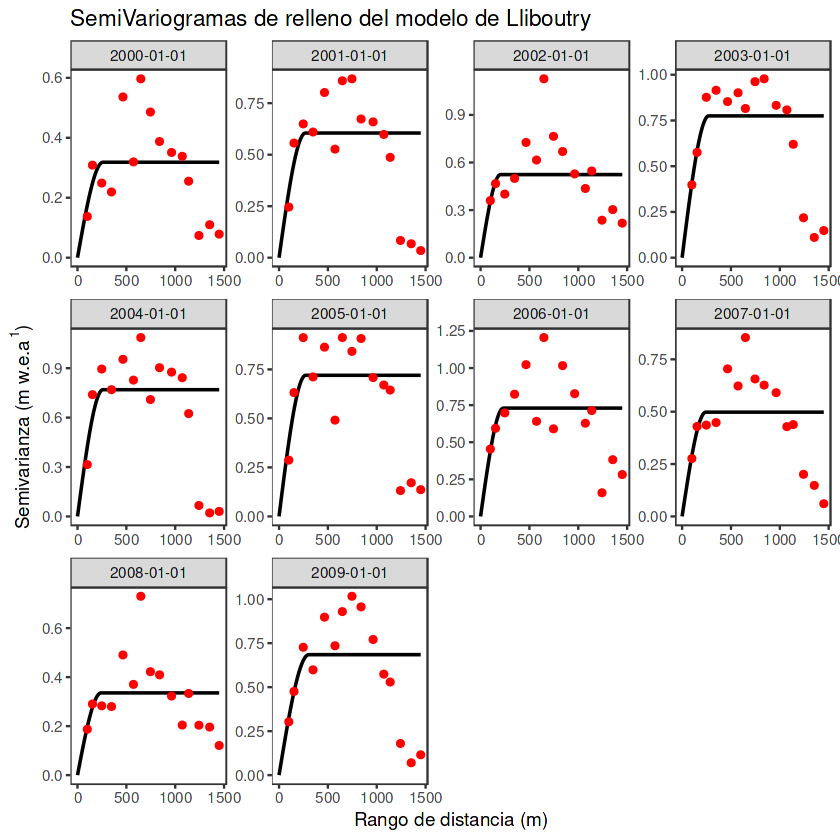

In [13]:
plot(p)

## Análisis de errores

In [14]:
  e.stkabl <- 0.1 #m w.e.yr-1 Gerbaux et al., 2005 e.stkabl <- 0.1
  e.densabl <- 0.00 # d_acc = 0.9
  e.pitacc <- 0.4 #m w.e.yr-1 Gerbaux et al., 2005 e.pitacc <- 0.4
  e.densacc <- 0.025 # d_acc = 0.5

### Error de la medición del punto, considerando el número de stacks

In [15]:
e.Abl <- e.stkabl/sqrt(n.stk.abl)
e.Acc <- ifelse(n.stk.acc==0, 0, e.pitacc/sqrt(n.stk.acc))
e_mesMB <- sqrt(e.Abl^2+e.Acc^2)

### Densidad de error, considerando el número de stacks

In [16]:
e_dcice <- e.densabl/sqrt(n.stk.abl)
e_dcfirm <- ifelse(n.stk.acc==0, 0, e.densacc/sqrt(n.stk.acc))
e_dc <- sqrt(e_dcfirm^2+e_dcice^2)

### Error por modelo de interpolación

In [17]:
e_glc.point.w.tot <- sqrt(e_mesMB^2+(sum(B_LMf_w$B_LMf_w_a)^2)*(e_dc^2))*sqrt(length(Nyear))
e_glc.point.idw.tot <- sqrt(e_mesMB^2+(sum(B_LMf_idw$B_LMf_idw_a)^2)*(e_dc^2))*sqrt(length(Nyear))
e_glc.point.krg.tot <- sqrt(e_mesMB^2+(sum(B_LMf_krg$B_LMf_krg_a)^2)*(e_dc^2))*sqrt(length(Nyear))

### Representatividad local de medidas locales

In [18]:
e_repres.yr <- sd(unlist(bit_LMf[-c(1:3)]), na.rm = T) / sqrt(unlist(lapply(stat.idw.CV_LMf, function(sublist) sublist[[1]]), use.names=F)[1])
e_repres.tot <- sd(unlist(bit_LMf[-c(1:3)]), na.rm = T) / sqrt(unlist(lapply(stat.idw.CV_LMf, function(sublist) sublist[[1]]), use.names=F)[1])

### Error del método de interpolación de área ponderada

In [19]:
std.w <- stat.w.sd^2
n_obs <- unlist(lapply(stat.idw.CV_LMf, function(sublist) sublist[[1]]), use.names=F)
e_w_sd.tot <- sqrt(sum(std.w)/((n_obs[1]*length(Nyear))-length(Nyear))) 

### Error del método de interpolación IDW

In [20]:
std.idw <- unlist(lapply(stat.idw.CV_LMf, function(sublist) sublist[[5]]), use.names=F)^2
n_obs <- unlist(lapply(stat.idw.CV_LMf, function(sublist) sublist[[1]]), use.names=F)
e_idw_sd.tot <- sqrt(sum(std.idw)/((n_obs[1]*length(Nyear))-length(Nyear)))

### Error del método de interpolación Kriging

In [21]:
std.krg <- unlist(lapply(stat.krg.CV_LMf, function(sublist) sublist[[5]]), use.names=F)^2
n_obs <- unlist(lapply(stat.krg.CV_LMf, function(sublist) sublist[[1]]), use.names=F)
e_krg_sd.tot <- sqrt(sum(std.krg)/((n_obs[1]*length(Nyear))-length(Nyear)))

### Error espacial

In [22]:
e_glc.spatial.w.tot <- sqrt(e_repres.tot^2+e_w_sd.tot^2)
e_glc.spatial.idw.tot <- sqrt(e_repres.tot^2+e_idw_sd.tot^2)
e_glc.spatial.krg.tot <- sqrt(e_repres.tot^2+e_krg_sd.tot^2)
rm(std.idw, std.krg)

### Error de cambios de área superficial

Se asume 5m de error en la determinación del área

In [23]:
e_glac.area.w.tot <-  e_glc.point.w.tot * as.numeric((0.5*st_length(st_boundary(shape_list[[1]]))*3)/st_area(shape_list[[1]])) 
e_glac.area.idw.tot <- e_glc.point.idw.tot * as.numeric((0.5*st_length(st_boundary(shape_list[[1]]))*3)/st_area(shape_list[[1]])) 
e_glac.area.krg.tot <- e_glc.point.krg.tot * as.numeric((0.5*st_length(st_boundary(shape_list[[1]]))*3)/st_area(shape_list[[1]])) 

### Error del balance de masa glaciológico

In [24]:
E_glc.w.tot <- sqrt(e_glc.point.w.tot^2+e_glc.spatial.w.tot^2+e_glac.area.w.tot^2)
E_glc.w.yr <-  E_glc.w.tot / sqrt(length(Nyear))

E_glc.idw.tot <- sqrt(e_glc.point.idw.tot^2+e_glc.point.idw.tot^2+e_glac.area.idw.tot^2)
E_glc.idw.yr <- E_glc.idw.tot / sqrt(length(Nyear))

E_glc.krg.tot <- sqrt(e_glc.point.krg.tot^2+e_glc.point.krg.tot^2+e_glac.area.krg.tot^2)
E_glc.krg.yr <- E_glc.krg.tot / sqrt(length(Nyear)) 

### Balance de Masa Geodésico (Dussaillant et al., 2019)

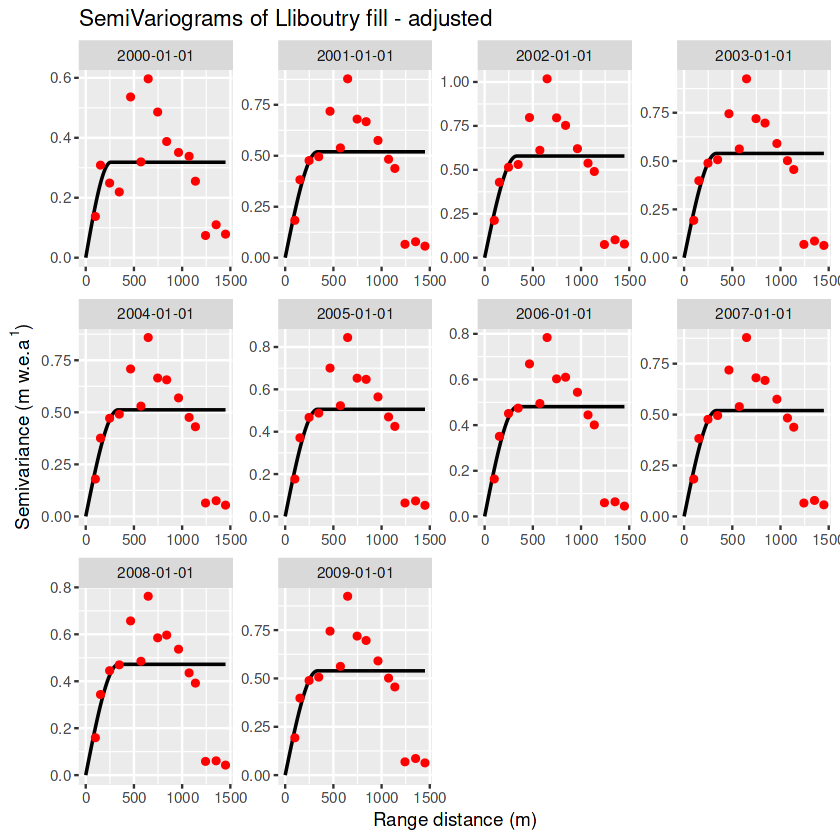

In [25]:
options(warn = -1)
suppressMessages(suppressWarnings({
invisible(capture.output({  
if (!is.null(geodetic_balance)){
    geo_df <- data.frame(read_excel(geodetic_balance, sheet = 1))
    #######################################################################################
    #=== VALIDACIÓN DE BALANCE DE MASA GEODÉSICO - AJUSTE GEODÉSICO (Zemp et al., 2013)
    #=== CÁLCULO DEL BALANCE DE MASA DISTRIBUIDO CALIBRADO CON AJUSTE GEODÉSICO =====
    # Frecuentemente el periodo de monitoreo cliaciologico no coincide con el monitoreo geodesico
    # en estos casos se asume un rango de tolerancia de 3 años (antes/despues) para suponer que la tendencia
    # observada en el periodo coincidente se mantiene
    yr_glc_o <- as.numeric(substr(Nyear[1], 1, 4))
    yr_glc_f <- as.numeric(substr(Nyear[length(Nyear)], 1, 4))
    
    ai_adj_geo <- list()
    bit_LM_w_adj <- list()
    bit_LMf_w_adj <- list()
    bit_LM_idw_adj <- list()
    bit_LMf_idw_adj <- list()
    bit_LM_krg_adj <- list()
    bit_LMf_krg_adj <- list()
    B_LMf_w$B_LMfadj_w_a <- B_LMf_w$B_LMf_w_a
    B_LMf_idw$B_LMfadj_idw_a <- B_LMf_idw$B_LMf_idw_a
    B_LMf_krg$B_LMfadj_krg_a <- B_LMf_krg$B_LMf_krg_a
    E_glc_adj_a <- list() 
    for (k in 1:(nrow(geo_df)-1)) {
      # Define the glaciological time series
      yr_geo_o <- geo_df$yr_geo_o[k]
      yr_geo_f <- geo_df$yr_geo_f[k] 
      
      # Calculate the limits with tolerance of +/-2 years 
      # This script first expands the reference interval by a tolerance of 2 years in either direction. 
      # Then it checks whether each interval falls within this extended reference interval. 
      # If it does, it further checks if it crosses the start or end boundary of the original reference interval to determine how it could be distributed.
      # Check if the interval is within the limits and return message
      # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
      if (yr_glc_o <= yr_geo_o & yr_glc_f >= yr_geo_f) {
        idx1 <- which(B_LMf_w$Nyear==paste(yr_geo_o, substr(Nyear[1], 5, 10), sep = ""))
        idx2 <- which(B_LMf_w$Nyear==paste(yr_geo_f, substr(Nyear[1], 5, 10), sep = ""))
        # Analisis estadistico de discrepancia para ajuste
        source("./functions/Reanal_glac_geo_Zemp.R")
        Reanal_glac_geoR = Reanal_glac_geo(B_LMf_w, idx1, idx2, e_mesMB, e_dc, geo_df, k, e_repres.tot, std.w, n_obs, shape_list)
        e_Bgl_a <- Reanal_glac_geoR$e_Bgl_a
        E_glc_adj_a[[k]] <- e_Bgl_a
        names(E_glc_adj_a[[k]]) <- c(paste0("period ", k))
        aux <- Reanal_glac_geoR$aux
        if(aux==1){
          # 1. Geodetic calibration (Annual calibration) contempla el ajuste convencional
          # Ajuste de los datos por de Bm calculado por el metodo de area ponderada
          B_LMf_w$aux <- B_LMf_w$B_LMfadj_w_a - mean(B_LMf_w$B_LMfadj_w_a[(idx1+1):idx2], na.rm=T) + (geo_df$B_geo_a[k])
          B_LMf_w$B_LMfadj_w_a[(idx1+1):idx2] <- B_LMf_w$aux[(idx1+1):idx2]
          
          B_LMf_idw$aux <- B_LMf_idw$B_LMfadj_idw_a - mean(B_LMf_idw$B_LMfadj_idw_a[(idx1+1):idx2], na.rm=T) + (geo_df$B_geo_a[k])
          B_LMf_idw$B_LMfadj_idw_a[(idx1+1):idx2] <- B_LMf_idw$aux[(idx1+1):idx2]
          
          B_LMf_krg$aux <- B_LMf_krg$B_LMfadj_krg_a - mean(B_LMf_krg$B_LMfadj_krg_a[(idx1+1):idx2], na.rm=T) + (geo_df$B_geo_a[k])
          B_LMf_krg$B_LMfadj_krg_a[(idx1+1):idx2] <- B_LMf_krg$aux[(idx1+1):idx2]
          
          # 2. Geodetic calibration (pixel by pixel) asumiendo que el bm_geo_a es el mismo para todos los anios se ajusta el ai (balance promedio)
          # hipotesis de densidad 850 kg/m3, (Huss, 2013) - periodo comun
          # LMf salida Lliboutry ajustado con geodesico LMf_adj
          ai_adj <- data.frame(rawData$ai)
          # Calculo de Delta ai ajustado con BM geodesico
          ai_adj$db_i_w_adj_geo <- (mean(B_LMf_w$B_LMf_w_a[(idx1+1):idx2])-mean(B_LMf_w$B_LMfadj_w_a[(idx1+1):idx2]))/rawData$yi # Balance area ponderada
          ai_adj$db_i_idw_adj_geo <- (mean(B_LMf_idw$B_LMf_idw_a[(idx1+1):idx2])-mean(B_LMf_idw$B_LMfadj_idw_a[(idx1+1):idx2]))/rawData$yi # Balance IDW
          ai_adj$db_i_krg_adj_geo <- (mean(B_LMf_krg$B_LMf_krg_a[(idx1+1):idx2])-mean(B_LMf_krg$B_LMfadj_krg_a[(idx1+1):idx2]))/rawData$yi # Balance kriging
          
          ai_adj$ai_w_adj_geo <- (rawData$ao_i - ai_adj$db_i_w_adj_geo)*rawData$yi
          ai_adj$ai_idw_adj_geo <- (rawData$ao_i - ai_adj$db_i_idw_adj_geo)*rawData$yi
          ai_adj$ai_krg_adj_geo <- (rawData$ao_i - ai_adj$db_i_krg_adj_geo)*rawData$yi
          
          ai_adj$ao_i_w_adj_geo <- ai_adj$ai_w_adj_geo/rawData$yi
          ai_adj$ao_i_idw_adj_geo <- ai_adj$ai_idw_adj_geo/rawData$yi 
          ai_adj$ao_i_krg_adj_geo <- ai_adj$ai_idw_adj_geo/rawData$yi 
          
          ai_adj_geo[[k]] <- ai_adj
          names(ai_adj_geo)[k] <- c(paste("geodesic", k, "period"))
          
          # Ajuste geodésico - area ponderada
          bit_SC <- rawData[Nyear]
          for (i in 1:nrow(bit_SC)){
            for (j in 1:length(Nyear)){
              bit_SC[i,j] <- ((ai_adj$ao_i_w_adj_geo[i]) + bo_t[j])*rawData$yi[i]
            }
          }
          bit_LMf_w_adj[[k]] <- bit_SC[(idx1+1):idx2]
          names(bit_LMf_w_adj)[k] <- c(paste("bi_adj_geo", k, "period"))
          
          ## Ajuste geodésico - idw
          bit_SC <- rawData[Nyear]
          for (i in 1:nrow(bit_SC)){
            for (j in 1:length(Nyear)){
              bit_SC[i,j] <- ((ai_adj$ao_i_idw_adj_geo[i]) + bo_t[j])*rawData$yi[i]
            }
          }
          bit_LMf_idw_adj[[k]] <- bit_SC[(idx1+1):idx2]
          names(bit_LMf_idw_adj)[k] <- c(paste("bi_adj_geo", k, "period"))
          
          ## Ajuste geodésico - krg
          bit_SC <- rawData[Nyear]
          for (i in 1:nrow(bit_SC)){
            for (j in 1:length(Nyear)){
              bit_SC[i,j] <- ((ai_adj$ao_i_krg_adj_geo[i]) + bo_t[j])*rawData$yi[i]
            }
          }
          bit_LMf_krg_adj[[k]] <- bit_SC[(idx1+1):idx2]
          names(bit_LMf_krg_adj)[k] <- c(paste("bi_adj_geo", k, "period"))
          
        } else {
          bit_LM_w_adj[[k]] <- bit_LM[Nyear][(idx1+1):idx2]
          bit_LMf_w_adj[[k]] <- bit_LMf[Nyear][(idx1+1):idx2]
          names(bit_LMf_w_adj)[k] <- c(paste("bi_adj_geo", k, "period"))
          
          bit_LM_idw_adj[[k]] <- bit_LM[Nyear][(idx1+1):idx2]
          bit_LMf_idw_adj[[k]] <- bit_LMf[Nyear][(idx1+1):idx2]
          names(bit_LMf_idw_adj)[k] <- c(paste("bi_adj_geo", k, "period"))
          
          bit_LM_krg_adj[[k]] <- bit_LM[Nyear][(idx1+1):idx2]
          bit_LMf_krg_adj[[k]] <- bit_LMf[Nyear][(idx1+1):idx2]
          names(bit_LMf_krg_adj)[k] <- c(paste("bi_adj_geo", k, "period"))}
      } 
    }
    if("aux" %in% colnames(B_LMf_w)){
      # Balance acumulado de los balances anuales Bm_a calculado 
      B_LMf_w$B_LMfadj_w_tot <- cumsum(B_LMf_w$B_LMfadj_w_a) # metodo area ponderada
      B_LMf_idw$B_LMfadj_idw_tot <- cumsum(B_LMf_idw$B_LMfadj_idw_a) # metodo idw
      B_LMf_krg$B_LMfadj_krg_tot <- cumsum(B_LMf_krg$B_LMfadj_krg_a) #metodo kriging
      
      # Construccion de matrices para la interpolacion
      # Area Ponderada
      bit_LMf_w_adj <- do.call(cbind, bit_LMf_w_adj)
      colnames(bit_LMf_w_adj) <- substr(colnames(bit_LMf_w_adj), 21, nchar(colnames(bit_LMf_w_adj))) # Remover los 21 primeros caracteres de los nombres de las columnas
      anos_faltantes <- setdiff(names(bit_LMf[Nyear]), names(bit_LMf_w_adj))
      for (ano in anos_faltantes) { # Rellenar los años faltantes en B usando los valores de A
        bit_LMf_w_adj[[ano]] <- bit_LMf[[ano]]
      }
      bit_LMf_w_adj <- bit_LMf_w_adj[, sort(names(bit_LMf_w_adj))]
      bit_LMf_w_adj <- cbind(rawData[c(1:3)], bit_LMf_w_adj) 
      att <- drop_na(bit_LMf_w_adj, x)
      addWorksheet(wb, "out_bit_LMf_w_adj")
      writeData(wb, sheet = "out_bit_LMf_w_adj", att)
  
      # IDW
      bit_LMf_idw_adj <- do.call(cbind, bit_LMf_idw_adj)
      colnames(bit_LMf_idw_adj) <- substr(colnames(bit_LMf_idw_adj), 21, nchar(colnames(bit_LMf_idw_adj))) # Remover los 21 primeros caracteres de los nombres de las columnas
      anos_faltantes <- setdiff(names(bit_LMf[Nyear]), names(bit_LMf_idw_adj))
      for (ano in anos_faltantes) { # Rellenar los años faltantes en B usando los valores de A
        bit_LMf_idw_adj[[ano]] <- bit_LMf[[ano]]
      }
      bit_LMf_idw_adj <- bit_LMf_idw_adj[, sort(names(bit_LMf_idw_adj))]
      bit_LMf_idw_adj <- cbind(rawData[c(1:3)], bit_LMf_idw_adj) 
      att <- drop_na(bit_LMf_idw_adj, x)
      addWorksheet(wb, "out_bit_LMf_idw_adj")
      writeData(wb, sheet = "out_bit_LMf_idw_adj", att)
      
      # Kriging
      bit_LMf_krg_adj <- do.call(cbind, bit_LMf_krg_adj)
      colnames(bit_LMf_krg_adj) <- substr(colnames(bit_LMf_krg_adj), 21, nchar(colnames(bit_LMf_krg_adj))) # Remover los 21 primeros caracteres de los nombres de las columnas
      anos_faltantes <- setdiff(names(bit_LMf[Nyear]), names(bit_LMf_krg_adj))
      for (ano in anos_faltantes) {# Rellenar los años faltantes en B usando los valores de A
        bit_LMf_krg_adj[[ano]] <- bit_LMf[[ano]]
      }
      bit_LMf_krg_adj <- bit_LMf_krg_adj[, sort(names(bit_LMf_krg_adj))]
      bit_LMf_krg_adj <- cbind(rawData[c(1:3)], bit_LMf_krg_adj) 
      att <- drop_na(bit_LMf_krg_adj, x)
      addWorksheet(wb, "out_bit_LMf_krg_adj")
      writeData(wb, sheet = "out_bit_LMf_krg_adj", att)
      
      # Mean Adjusted Mass Balance 
      ai_df_w_adj <- cbind(XY_coords, value = apply(bit_LMf_w_adj[Nyear], 1, mean, na.rm = T)) #dataframe de valores ai
      ai_df_w_adj$value[is.nan(ai_df_w_adj$value)] <- NA # Replace NaN with NA
      
      ai_df_idw_adj <- cbind(XY_coords, value = apply(bit_LMf_idw_adj[Nyear], 1, mean, na.rm = T)) #dataframe de valores ai
      ai_df_idw_adj$value[is.nan(ai_df_idw_adj$value)] <- NA # Replace NaN with NA
      
      ai_df_krg_adj <- cbind(XY_coords, value = apply(bit_LMf_krg_adj[Nyear], 1, mean, na.rm = T)) #dataframe de valores ai
      ai_df_krg_adj$value[is.nan(ai_df_krg_adj$value)] <- NA # Replace NaN with NA 
      
      aux=1
      B_LMf_w <- subset(B_LMf_w, select = -aux)
      B_LMf_idw <- subset(B_LMf_idw, select = -aux)
      B_LMf_krg <- subset(B_LMf_krg, select = -aux)
    }
    ##################################################################################
    #=== CALCULATION OF DISTRIBUTED MASS BALANCE FOR DATA WITH GEODETIC ADJUSTMENT ===
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # 1. Weighted area/altitude range method for geodetically adjusted data from the Nonlinear Lliboutry Model
    # From the output files *.csv we can compute glacier variables
    if(aux==1) {
      WAreaR = WArea(bit_LMf_w_adj, m, shapes_path, dem, crsID, shap, Nyear, aux)
      bit_LMf_w_adj_rg <- WAreaR$bit_LMf_w_adj_rg
      B_LMf_w_adj_rg <- WAreaR$B_LMf_w_adj_rg
      B_LMf_w <- cbind(B_LMf_w, B_LMf_w_adj_rg)
      # Export the DataFrame obtained through the Weighted Area Method.
      addWorksheet(wb, "out_bit_LMf_w_adj_rg_a")
      writeData(wb, sheet = "out_bit_LMf_w_adj_rg_a", bit_LMf_w_adj_rg)
      
      addWorksheet(wb, "out_B_LMf_w")
      writeData(wb, sheet = "out_B_LMf_w", B_LMf_w)
      aux=1}
    
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # 2. Inverse Distance Weighted interpolation Method for geodetically adjusted data from the Nonlinear Lliboutry Model
    if(aux==1) {
      IdwGBR = IdwGB(bit_LMf_idw_adj, dem, crsID, brick_raw, Nyear, aux)
      bit_LMf_idw_adj_sp = IdwGBR$bit_LMf_idw_adj_sp
      # Creation and masking of RasterBrick objects according to the annual area
      att <- BrickBuilder(list(LMf_idw_adj_sp = bit_LMf_idw_adj_sp), brick_raw, Nyear)
      brick_list$LMf_idw_adj_sp <- lapply(setNames(1:length(Nyear), Nyear), function(i){
        raster::mask(att$LMf_idw_adj_sp[[i]], as(st_zm(st_as_sf(shape_list[[shap[i]]])), "Spatial"))
      }) %>% brick()
      
      # Calculation of the distributed mass balance by IDW
      B_LMf_idw_adj_sp <- data.frame(area_glc = sapply(1:length(Nyear), function(i){
        # Calculate area using sf for sf objects
        sum(st_area(shape_list[[shap[i]]]))
      }),
      LMf_idw_adj_sp = sapply(1:length(Nyear), function(i){
        cellStats(brick_list$LMf_idw_adj_sp[[i]], stat='sum', na.rm=TRUE, asSample=TRUE)
      })
      )
      
      B_LMf_idw_adj_sp$B_LMf_idw_adj_sp_a <- B_LMf_idw_adj_sp$LMf_idw_adj_sp*(Resolution^2)/B_LMf_idw_adj_sp$area_glc
      B_LMf_idw_adj_sp$B_LMf_idw_adj_sp_tot <- cumsum(B_LMf_idw_adj_sp$B_LMf_idw_adj_sp_a)
      B_LMf_idw <- cbind(B_LMf_idw, B_LMf_idw_adj_sp[,2:4])
      
      # Export the DataFrame obtained
      addWorksheet(wb, "out_bit_LMf_idw_adj_sp")
      writeData(wb, sheet = "out_bit_LMf_idw_adj_sp", bit_LMf_idw_adj_sp)
      
      addWorksheet(wb, "out_B_LMf_idw")
      writeData(wb, sheet = "out_B_LMf_idw", B_LMf_idw)
      aux=1}
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # 3. Kriging method for geodetically adjusted data from the Nonlinear Lliboutry Model
    if(aux==1) {
      KrgGBR = KrgGB(bit_LMf_krg_adj, dem, crsID, brick_raw, Nyear, aux)
      varplot1_LMfadj_sp = KrgGBR$varplot1_LMfadj_sp
      varplot2_LMfadj_sp = KrgGBR$varplot2_LMfadj_sp
      bit_LMf_krg_adj_sp = KrgGBR$bit_LMf_krg_adj_sp
      # Variogram plot of adjusted annual balance
      print(
        ggplot(varplot1_LMfadj_sp, aes(x = dist, y = gamma)) +
          geom_line(data = varplot2_LMfadj_sp, size = 0.75) +
          geom_point(colour = "red") +
          facet_wrap(.~year, scales = "free") + 
          ggtitle("SemiVariograms of Lliboutry fill - adjusted") +
          xlab("Range distance (m)") + ylab(expression("Semivariance (m w.e.a"^-1*")"))
      )
      
      # Creation and masking of RasterBrick objects according to the annual area
      att <- BrickBuilder(list(LMf_krg_adj_sp = bit_LMf_krg_adj_sp), brick_raw, Nyear)
      brick_list$LMf_krg_adj_sp <- lapply(setNames(1:length(Nyear), Nyear), function(i){
        raster::mask(att$LMf_krg_adj_sp[[i]], as(st_zm(st_as_sf(shape_list[[shap[i]]])), "Spatial"))
      }) %>% brick()
      
      # Calculation of the distributed mass balance by IDW
      B_LMf_krg_adj_sp <-data.frame(
        area_glc = sapply(1:length(Nyear), function(i){
          #raster::area(shape_list[[shap[i]]])
          # Calculate area using sf for sf objects
          sum(st_area(shape_list[[shap[i]]]))
        }),
        LMf_krg_adj_sp = sapply(1:length(Nyear), function(i){
          cellStats(brick_list$LMf_krg_adj_sp[[i]], stat='sum', na.rm=TRUE, asSample=TRUE)
        })
      )
      
      B_LMf_krg_adj_sp$B_LMf_krg_adj_sp_a <- B_LMf_krg_adj_sp$LMf_krg_adj_sp*(Resolution^2)/B_LMf_krg_adj_sp$area_glc # Balance krig ponderado a la talla del pixel
      B_LMf_krg_adj_sp$B_LMf_krg_adj_sp_tot <- cumsum(B_LMf_krg_adj_sp$B_LMf_krg_adj_sp_a)
      B_LMf_krg <- cbind(B_LMf_krg, B_LMf_krg_adj_sp[2:4])
      
      # Export the DataFrame obtained
      addWorksheet(wb, "out_bit_LMf_krg_adj_sp")
      writeData(wb, sheet = "out_bit_LMf_krg_adj_sp", bit_LMf_krg_adj_sp)
      
      addWorksheet(wb, "out_B_LMf_krg")
      writeData(wb, sheet = "out_B_LMf_krg", B_LMf_krg)
      aux=1}
  }
}))
}))

In [26]:
source("./functions/Contour_tmap_K.R")

In [27]:
options(warn = -1)
invisible(capture.output({
if(aux==1){
    mapa_contornos_idw = ContourPlot_tmap(
      ai_df_idw_adj,
      "idw",
      "Balance de masa promedio ajustado",
      brick_raw,
      shape_list,
      dem = dem,
      crsID = crsID
    )
    mapa_contornos_krg = ContourPlot_tmap(
      ai_df_krg_adj,
      "krig",
      "Balance de masa promedio ajustado",
      brick_raw,
      shape_list,
      dem = dem,
      crsID = crsID
    )
  } else {
    mapa_contornos_idw = ContourPlot_tmap(
      ai_df,
      "idw",
      "Balance de masa promedio",
      brick_raw,
      shape_list,
      dem = dem,
      crsID = crsID
    )
    mapa_contornos_krg = ContourPlot_tmap(
      ai_df,
      "krig",
      "Balance de masa promedio",
      brick_raw,
      shape_list,
      dem = dem,
      crsID = crsID
    )
  }
}))

Spherical geometry (s2) switched off



In [28]:
options(warn = -1)
suppressWarnings({
  widget <- tmap_leaflet(mapa_contornos_krg)
})
widget 

HTML widgets cannot be represented in plain text (need html)

In [29]:
RasterPlot_tmap <- function(obj, showraw, title, brick_raw, Nyear, shape_list, crsID) {
  
  # 1. Raster multicapa
  r <- rast(obj)
  Nyear <- as.Date(Nyear)
  
  # 2. Extraer años
  if (inherits(Nyear, "Date")) {
    years <- as.integer(format(Nyear, "%Y"))
  } else {
    years <- as.integer(Nyear)
  }
  
  # 3. Nombres de capas
  names(r) <- paste0(years, "-", years + 1)
  
  # 4. Shapefile
  poly_sf <- if (inherits(shape_list[[1]], "sf")) {
    st_zm(shape_list[[1]])
  } else {
    st_as_sf(st_zm(shape_list[[1]]))
  }
  
  # 5. Paleta divergente centrada en 0 (global para todas las capas)
  Min_val <- floor(min(values(r), na.rm = TRUE))
  Max_val <- ceiling(max(values(r), na.rm = TRUE))
  nHalf <- 1500
  cp <- brewer.pal(11, "RdBu")
  rc1 <- colorRampPalette(c(cp[1], cp[3], cp[6]))(nHalf)
  rc2 <- colorRampPalette(c(cp[6], cp[9], cp[11]))(nHalf)
  rampcols <- c(rc1, rc2)
  
  # 6. Detectar versión de tmap
  tmap_ver <- packageVersion("tmap")
  message("Construyendo mapa raster con tmap v", tmap_ver)
  
  # 7. Crear breaks para v3
  breaks_vec <- seq(Min_val, Max_val, length.out = 100)
  
  # 8. Construir mapa según versión
  map <- tryCatch({
  if (tmap_ver >= "4.0") {
    # Sintaxis tmap v4
    message("Usando sintaxis tmap v4")
    m <- tm_shape(r) +
      tm_raster(
        col.scale = tm_scale_continuous(
          values = rampcols,
          midpoint = 0,
          limits = c(Min_val, Max_val)
        ),
        col.legend = tm_legend(title = "Balance (m w.e./año)")
      ) +
      tm_facets(
        as.layers = TRUE, 
        sync = TRUE,
        free.scales = FALSE,
        free.legend = FALSE  # ← AGREGAR ESTO
      ) +
      tm_shape(poly_sf) +
      tm_borders(lwd = 2, col = "black") +
      tm_layout(
        title = title,
        legend.outside = FALSE, 
        frame = FALSE,
        legend.position = c("right", "bottom"),
        legend.only = FALSE  # ← AGREGAR ESTO
      )
    
  } else {
    # Sintaxis tmap v3
    message("Usando sintaxis tmap v3")
    m <- tm_shape(r) +
      tm_raster(
        style = "cont",
        palette = rampcols,
        midpoint = 0,
        breaks = breaks_vec,
        title = "Balance (m w.e./año)",
        legend.show = TRUE  # ← Asegurar que se muestre
      ) +
      tm_facets(
        as.layers = TRUE, 
        sync = TRUE,
        free.scales = FALSE,
        showNA = FALSE  # ← AGREGAR ESTO
      ) +
      tm_shape(poly_sf) +
      tm_borders(lwd = 2, col = "black") +
      tm_layout(
        title = title,
        legend.outside = FALSE, 
        frame = FALSE,
        legend.position = c("right", "bottom"),
        legend.only = FALSE  # ← AGREGAR ESTO
      )
  }
    
    m
  }, error = function(e) {
    stop("Error al construir mapa raster: ", e$message)
  })
  
  message("Mapa raster creado exitosamente")
  return(map)
}
mapa_raster = RasterPlot_tmap(brick_list$LMf, FALSE, "Balance de Masa por año", brick_list$Raw, Nyear, shape_list, crsID)
options(warn = -1)
suppressWarnings({
  widget <- tmap_leaflet(mapa_raster)
})
widget 

Construyendo mapa raster con tmap v3.3.4



Usando sintaxis tmap v3



Mapa raster creado exitosamente



legend.postion is used for plot mode. Use view.legend.position in tm_view to set the legend position in view mode.



HTML widgets cannot be represented in plain text (need html)